# 模型训练

本实验使用MindSpore实现网络模型的训练，包括训练过程中关键模块的基本构建和训练流程的实现。结合课程学习，通过本实验可以了解模型训练的整体流程，掌握模块构建的方法以及模型训练的技巧。

## 1 关键模块的基本构建

### 1.1 超参数

超参数是可以调整的参数，可以控制模型训练优化的过程，不同的超参数值可能会影响模型训练和收敛速度。目前深度学习模型采用的优化器算法中除了梯度本身，批次大小和学习率直接决定了优化器的优化效果，此外训练轮次也影响着模型的权重更新情况，从优化本身来看它们是影响模型性能收敛最重要的参数。因此，我们一般会定义以下超参数用于训练：

- 训练轮次（epoch）

- 批次大小（batch size）

- 学习率（learning rate）

这里设置训练轮次为10，批次大小为32，学习率为0.01，代码示例如下：

In [1]:
epochs = 10
batch_size = 32
learning_rate = 0.01

### 1.2 损失函数

损失函数用来评价模型的**预测值**和**真实值**之间的误差。

`mindspore.nn.loss`提供了许多常用的损失函数，如`L1Loss`、`SoftmaxCrossEntropyWithLogits`、`MSELoss`、`SmoothL1Loss`等，详情可参考[API文档](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore.nn.html#%E6%8D%9F%E5%A4%B1%E5%87%BD%E6%95%B0)。

在这里，我们使用交叉熵损失函数[SoftmaxCrossEntropyWithLogits](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.SoftmaxCrossEntropyWithLogits.html)举例。

`SoftmaxCrossEntropyWithLogits`接口的参数如下：

- `sparse` ：指定真实值是否使用稀疏格式。

- `reduction`：指定应用于输出结果的计算方式。取值为”mean”，”sum”，或”none”。取值为”none”，则不执行reduction。

我们给定预测值和目标值，通过交叉熵损失函数计算出输入概率（使用softmax函数计算）和目标值之间的误差，代码样例如下：

In [2]:
import numpy as np
import mindspore.nn as nn
import mindspore
from mindspore import Tensor

loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
output_data = Tensor(np.array([[3, 5, 6, 9, 12, 33, 42, 12, 32, 72]]), mindspore.float32)
target_data = Tensor(np.array([1]), mindspore.int32)
output = loss(output_data, target_data)
print(output)

67.0


### 1.3 优化器

模型训练过程中，优化器函数用于计算和更新梯度，合适的优化器函数可以有效减少训练时间，提高模型性能。有时候最终模型效果不好，未必是特征或者模型设计的问题，很有可能是优化算法的问题。

MindSpore所有优化逻辑都封装在`Optimizer`对象中。`mindspore.nn`提供了许多常用的优化器函数，如`Momentum`、`Adam`、`SGD`、`RMSProp`等，详情可参考[API文档](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore.nn.html#%E4%BC%98%E5%8C%96%E5%99%A8)。在这里，我们使用`Momentum`优化器举例。

使用MindSpore提供的优化器时，我们需要构建一个优化器对象，首先需要指定待优化的网络参数，如网络中所有可以训练的`parameter`，即设置优化器的入参为模型`net`需要被更新的参数`net.trainable_params()`。然后，设置优化器的参数选项，比如学习率、权重衰减等。代码样例如下：

In [3]:
import mindspore.nn as nn
from mindvision.classification.models import lenet

momentum = 0.9
net = lenet(num_classes=10, pretrained=False)
optim = nn.Momentum(net.trainable_params(), learning_rate, momentum)

### 1.4 评价指标

当训练任务结束，常常需要评价函数（Metrics）来评估模型的好坏。不同的训练任务往往需要不同的评价函数。

MindSpore提供了大部分常见任务的评价函数，如`nn.Accuracy`、`nn.Pecision`、`nn.MAE`和`nn.MSE`等，详情可参考[API文档](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore.nn.html#%E8%AF%84%E4%BB%B7%E6%8C%87%E6%A0%87)。

`mindspore.Model`是用于训练和评估的高层API，可以将自定义或MindSpore已有的Metrics作为参数传入`metrics`参数中进行评估。这里我们以`nn.Accuracy`为例，演示在Model中使用内置评价指标的方法，代码样例如下：

In [4]:
import mindspore.nn as nn
from mindspore import Model
from mindvision.engine.callback import LossMonitor

# 定义model，使用内置的Accuracy评价函数
model = Model(net, loss, optim, metrics={"Accuracy": nn.Accuracy()})

## 2 训练流程

在本次实验中，我们将训练一个LeNet-5网络模型实现手写数字识别，以演示在MindSpore上进行模型训练的训练流程。

### 2.1 构建数据集

模型训练所用的数据集这里采用MNIST数据集。我们通过MindSpore Vision套件的[Mnist](https://www.mindspore.cn/vision/docs/zh-CN/r0.1/classification.html#mindvision.classification.dataset.Mnist)模块下载MNIST数据集并对其进行预处理。

数据集下载、解压到指定位置并进行数据处理的示例代码如下：

In [5]:
from mindvision.classification.dataset import Mnist

# 下载并处理MNIST数据集
download_train = Mnist(path="dataset/mnist", split="train", batch_size=32,
                       shuffle=True, resize=32, download=True)

download_eval = Mnist(path="dataset/mnist", split="test",
                      batch_size=32, resize=32, download=True)
# 生成训练数据集
dataset_train = download_train.run()
# 生成测试数据集
dataset_eval = download_eval.run()

[WARNING] ME(20200:11244,MainProcess):2023-01-07-21:48:02.290.617 [mindspore\dataset\core\config.py:646] For Windows and MacOS we forbid shared mem function temporarily.
9913344B [01:00, 163355.60B/s]                              
29696B [00:00, 81073.09B/s]                           
[WARNING] ME(20200:11244,MainProcess):2023-01-07-21:49:09.443.40 [mindspore\dataset\core\config.py:646] For Windows and MacOS we forbid shared mem function temporarily.
1649664B [00:16, 102151.20B/s]                              
5120B [00:00, 5106976.57B/s]           


下载的数据集文件的目录结构如下：

```text
./dataset/mnist/
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

### 2.2 定义模型

[LeNet-5](https://ieeexplore.ieee.org/document/726791)是Yann LeCun教授于1998年提出的一种典型的卷积神经网络，是CNN领域的第一篇经典之作。LeNet-5除去输入层共有7层，其中有2个卷积层，2个子采样层，3个全连接层。模型结构如下所示，用C代表卷积层，用S代表采样层，用F代表全连接层。

<div align=center>
    <img src="./images/lenet.png" width="80%" height="80%" />
</div>

构建LeNet-5模型的示例代码如下：

In [6]:
import mindspore.nn as nn


class LeNet5(nn.Cell):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, num_classes)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = LeNet5()

### 2.3 定义超参数、损失函数及优化器

要训练神经网络模型，需要定义超参数、损失函数和优化器函数。在这里设置训练轮次为10，批次大小为32，学习率为0.01，动量为0.9。

- 损失函数这里使用交叉熵损失函数[SoftmaxCrossEntropyWithLogits](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.SoftmaxCrossEntropyWithLogits.html)。
- 优化器这里使用[Momentum](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.Momentum.html)。

示例代码如下：

In [7]:
import mindspore.nn as nn

# 定义超参数
epochs = 5
batch_size = 32
learning_rate = 0.01
momentum = 0.9

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.Momentum(net.trainable_params(), learning_rate, momentum)

### 2.4 模型训练和评估

这里我们使用`Model`接口完成模型训练和评估。`Model`可以在一定程度上简化代码。例如：无需手动遍历数据集；在不需要自定义训练网络封装函数的场景下，可以借助`Model`自动构建训练网络；可以使用`Model`的`eval`接口进行模型评估，直接输出评估结果，无需手动调用评价指标的`clear`、`update`、`eval`函数等。另一方面，`Model`提供了很多高阶功能，如数据下沉、混合精度等，在不借助`Model`的情况下，使用这些功能需要花费较多的时间仿照`Model`进行自定义。

这里我们首先对MindSpore的Model进行基本介绍，然后讲解如何使用`Model`进行Lenet-5的模型训练、评估和推理。

#### 2.4.1 Model的基本介绍

[Model](https://mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore/mindspore.Model.html#mindspore.Model)是MindSpore提供的高阶API，可以进行模型训练、评估和推理。其接口的常用参数如下：

- `network`：用于训练或推理的神经网络。
- `loss_fn`：所使用的损失函数。
- `optimizer`：所使用的优化器。
- `metrics`：用于模型评估的评价函数。
- `eval_network`：模型评估所使用的网络，未定义情况下，`Model`会使用`networ`和`loss_fn`进行封装。

此外，`Model`还提供了以下接口用于模型训练、评估和推理：

- `train`：用于在训练集上进行模型训练。
- `eval`：用于在验证集上进行模型评估。
- `predict`：用于对输入的一组数据进行推理，输出预测结果。

#### 2.4.2 使用Model构建训练网络

对于一般场景的神经网络，可以在定义`Model`时指定前向网络`network`、损失函数`loss_fn`、优化器`optimizer`和评价函数`metrics`。

此时，`Model`会使用`network`作为前向网络，并自动调用`nn.WithLossCell`和`nn.TrainOneStepCell`构建训练网络，调用`nn.WithEvalCell`构建评估网络。

In [8]:
from mindspore import Model

# 使用Model构建训练网络
model = Model(network=net, loss_fn=net_loss, optimizer=net_opt, metrics={"Accuracy": nn.Accuracy()})

#### 2.4.3 模型训练

我们使用[train](https://www.mindspore.cn/docs/zh-CN/r1.8/api_python/mindspore/mindspore.Model.html)接口进行模型训练，`train`接口的常用参数如下：

- `epoch`：训练执行轮次，通常每个epoch都会使用全量数据集进行训练。
- `train_dataset`：一个训练数据集迭代器。
- `callbacks`：训练过程中需要执行的回调对象或者回调对象列表。

使用`train`接口执行模型训练的示例代码如下所示：

In [9]:
# 模型训练
model.train(epochs, dataset_train)

自此，我们就训练完了一个网络模型。

#### 2.4.4 Callback回调机制的使用

在模型训练过程中，为及时掌握网络模型的训练状态、实时观察网络模型各参数的变化情况和实现训练过程中用户自定义的一些操作，我们可以使用MindSpore提供的回调机制（Callback）来实现上述功能。

Callback回调机制一般用在网络模型训练过程`Model.train`中，通过对`Model.train`的`callbacks`参数传入不同的对象即可使用。

MindSpore的Model会按照Callback列表callbacks顺序执行回调函数。用户可以通过设置不同的回调类来实现在训练过程中或者训练后执行的功能，例如监控损失函数Loss、保存模型参数ckpt、动态调整参数lr、提前终止训练任务等。

下面以之前的模型训练为基础，介绍常用的MindSpore内置回调类之一的`LossMonitor`接口，并演示使用方法。

##### LossMonitor

为了监控训练过程中的损失函数值Loss变化情况，观察训练过程中每个epoch、每个step的运行时间，`MindSpore Vision`提供了[LossMonitor](https://mindspore.cn/vision/docs/zh-CN/r0.1/engine.html#mindvision.engine.callback.LossMonitor)接口。其接口的常用参数如下：

- `lr_init`：训练过程中学习率的变化时间表。
- `per_print_times`：训练过程中每多少步打印日志信息。

示例代码如下：

In [10]:
from mindvision.engine.callback import LossMonitor

# 开始训练，加载保存模型和参数回调函数，LossMonitor的入参0.01为学习率，1875为步长
model.train(epochs, dataset_train, callbacks=[LossMonitor(0.01, 1875)])

Epoch:[  0/  5], step:[ 1875/ 1875], loss:[0.018/0.045], time:6.994 ms, lr:0.01000
Epoch time: 22711.710 ms, per step time: 12.113 ms, avg loss: 0.045
Epoch:[  1/  5], step:[ 1875/ 1875], loss:[0.043/0.036], time:11.001 ms, lr:0.01000
Epoch time: 20587.112 ms, per step time: 10.980 ms, avg loss: 0.036
Epoch:[  2/  5], step:[ 1875/ 1875], loss:[0.001/0.029], time:6.999 ms, lr:0.01000
Epoch time: 19739.231 ms, per step time: 10.528 ms, avg loss: 0.029
Epoch:[  3/  5], step:[ 1875/ 1875], loss:[0.000/0.025], time:6.998 ms, lr:0.01000
Epoch time: 22227.273 ms, per step time: 11.855 ms, avg loss: 0.025
Epoch:[  4/  5], step:[ 1875/ 1875], loss:[0.001/0.020], time:12.006 ms, lr:0.01000
Epoch time: 20219.609 ms, per step time: 10.784 ms, avg loss: 0.020


从上面的打印结果可以看出，由于步长设置的是1875，所以模型训练过程中每1875个step会打印一条信息，loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。每个人运行的loss值有一定随机性，不一定完全相同。

除了`LossMonitor`接口外，`Model.train`中的`callbacks`参数还可调用`ModelCheckpoint`、`ValAccMonitor`接口实现模型保存的功能，这部分我们将在之后的模型保存部分进行介绍。

#### 2.4.5 模型评估

我们使用[eval](https://www.mindspore.cn/docs/zh-CN/r1.8/api_python/mindspore/mindspore.Model.html)接口进行模型评估，`eval`接口参数如下：

- `valid_dataset`：评估模型的数据集。
- `callbacks`：评估过程中需要执行的回调对象或回调对象列表。
- `dataset_sink_mode`：数据是否直接下沉至处理器进行处理。

示例代码如下：

In [11]:
acc = model.eval(dataset_eval)

print("{}".format(acc))

{'Accuracy': 0.9873798076923077}


从打印的信息中我们可以看到模型精度数据，示例中精度数据达到98%以上，模型质量良好。随着网络迭代次数增加，模型精度应该会进一步提高。

### 2.5 模型保存

在训练完网络完成后，下面我们将网络模型以文件的形式保存下来。保存模型的接口有主要2种：

- 简单的对网络模型进行直接保存，可以在训练前后进行保存。这种方式的优点是接口简单易用，但是只保留执行命令时候的网络模型状态；
- 在网络模型训练过程中进行保存，MindSpore在网络模型训练的过程中，自动保存训练时候设定好的epoch数和step数的参数，也就是把模型训练过程中产生的中间权重参数也保存下来，方便进行网络微调和停止训练；

#### 2.5.1 直接保存

我们可以使用MindSpore提供的[save_checkpoint](https://mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore/mindspore.save_checkpoint.html)接口直接保存模型。

在接口中传入训练后的网络`net`并设置保存路径为`"./MyNet/save_direct.ckpt"`，示例代码如下：

In [16]:
import mindspore as ms

ms.save_checkpoint(net, "./checkpoints/save_direct.ckpt")

> 执行代码前我们需要先在当前路径上手动创建一个名为`checkpoints`的文件夹，之后代码会在设定的文件路径上生成一个保存网络权重的`save_direct.ckpt`文件。

#### 2.5.2 训练过程中保存

这里即需要用到我们之前提到的Callback机制，通过调用两类不同的接口，可以分别实现不同的保存功能。

##### 1.ModelCheckpoint

在模型训练的过程中，使用`model.train`里面的`callbacks`参数传入保存模型的对象 [ModelCheckpoint](https://mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore.train.html#mindspore.train.callback.ModelCheckpoint)（一般与配置保存信息接口[CheckpointConfig](https://mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore.train.html#mindspore.train.callback.CheckpointConfig)配合使用），可以保存模型参数，生成CheckPoint(简称ckpt)文件。

用户可以根据具体需求通过设置`CheckpointConfig`来对CheckPoint策略进行配置。首先需要初始化一个`CheckpointConfig`类对象，用来设置保存策略。

- `save_checkpoint_steps`表示每隔多少个step保存一次。
- `keep_checkpoint_max`表示最多保存多少个CheckPoint文件。
- `prefix`表示生成CheckPoint文件的前缀名。
- `directory`表示存放文件的目录。

创建一个`ModelCheckpoint`对象把它传递给`model.train`方法，就可以在训练过程中使用CheckPoint功能了。

示例代码如下所示：

In [18]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 设置保存模型的配置信息
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

# 实例化保存模型回调接口，定义保存路径和前缀名
ckpoint = ModelCheckpoint(
    prefix="lenet", directory="./checkpoints/step_strategy", config=config_ck)

# 开始训练，加载保存模型和参数回调函数
model.train(2, dataset_train, callbacks=[ckpoint], dataset_sink_mode=False)

生成的CheckPoint文件的目录结构如下：

```text
./checkpoints/step_strategy
   ├──lenet-graph.meta # 编译后的计算图
   ├──lenet-1_1875.ckpt  # 文件的命名方式表示保存参数所在的epoch和step数，这里为第1个epoch的第1875个step的模型参数
   └──lenet-2_1875.ckpt  # 第2个epoch的第1875个step的模型参数
```

如果用户使用相同的前缀名，运行多次训练脚本，可能会生成同名CheckPoint文件。MindSpore为方便用户区分每次生成的文件，会在用户定义的前缀后添加"_"和数字加以区分。如果想要删除`.ckpt`文件时，请同步删除`.meta` 文件。

例：`lenet_3-2_1875.ckpt` 表示运行第3次脚本生成的第2个epoch的第1875个step的CheckPoint文件。

值得一提的是，用户通过设置`CheckpointConfig`可以采取不同的保存策略，上述代码我们采用的保存策略是迭代策略，是通过配置`CheckpointConfig`中的`save_checkpoint_steps`实现每隔1875个step就保存一个CheckPoint文件的功能。除此之外，我们还可以采用时间策略对模型进行保存，即在`CheckpointConfig`中根据训练的时长进行配置。

配置时间策略的参数如下：

- `save_checkpoint_seconds`：表示每隔多少秒保存一个CheckPoint文件。
- `keep_checkpoint_per_n_minutes`：表示每隔多少分钟保留一个CheckPoint文件。

对`CheckpointConfig`进行配置的示例代码如下：

In [19]:
from mindspore.train.callback import CheckpointConfig

config_ck = CheckpointConfig(save_checkpoint_seconds=30, keep_checkpoint_per_n_minutes=3)

上述代码配置`CheckpointConfig`的时间策略为每隔30秒保存一个CheckPoint文件，每隔3分钟保留一个CheckPoint文件，同样的，我们将`config_ck`导入一个新创建的ModelCheckpoint对象并把它传递给model.train方法，就可以在训练过程中按照时间策略对模型参数进行保存了。

> `save_checkpoint_seconds`参数不可与`save_checkpoint_steps`参数一起使用。如果同时设置了两个参数，则`save_checkpoint_seconds`参数无效。

##### 2.ValAccMonitor

Callback还可调用[ValAccMonitor](https://mindspore.cn/vision/docs/zh-CN/r0.1/engine.html#mindvision.engine.callback.ValAccMonitor)接口，实现边训练边验证，在训练过程中保存精度最优的网络模型和参数。

示例代码如下：

In [20]:
from mindvision.engine.callback import ValAccMonitor

# 开始训练，加载保存模型和参数回调函数
model.train(3, dataset_train, callbacks=[ValAccMonitor(model, dataset_eval, num_epochs=3, ckpt_directory="./checkpoints")])

--------------------
Epoch: [  1 /   3], Train Loss: [0.000], Accuracy:  0.990
--------------------
Epoch: [  2 /   3], Train Loss: [0.001], Accuracy:  0.989
--------------------
Epoch: [  3 /   3], Train Loss: [0.005], Accuracy:  0.989
End of validation the best Accuracy is:  0.990, save the best ckpt file in ./checkpoints\best.ckpt


上面代码执行后，模型经过三轮训练，精度最优的网络模型和参数会被保存在"./MyNet"目录下，文件名为"best.ckpt"。

### 2.6 模型加载

要加载模型权重，需要先创建一个相同模型的实例，然后使用[load_checkpoint](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore/mindspore.load_checkpoint.html)和[load_param_into_net](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/mindspore/mindspore.load_param_into_net.html)方法加载参数。

- `load_checkpoint`方法会把参数文件中的网络参数加载到字典`param_dict`中。

- `load_param_into_net`方法会把字典`param_dict`中的参数加载到网络或者优化器中，加载后，网络中的参数就是CheckPoint保存的。

示例代码如下：

In [21]:
from mindspore import load_checkpoint, load_param_into_net
from mindvision.classification.dataset import Mnist
from mindvision.classification.models import lenet

# 将模型参数存入parameter的字典中，这里加载的是采用ValAccMonitor接口保存下来的模型参数
param_dict = load_checkpoint("./checkpoints/best.ckpt")

# 重新定义一个LeNet5神经网络
net = LeNet5()

# 将参数加载到网络中
load_param_into_net(net, param_dict)

# 重新定义优化器函数
net_opt = nn.Momentum(net.trainable_params(), learning_rate=0.01, momentum=0.9)

model = Model(network=net, loss_fn=net_loss, optimizer=net_opt, metrics={"Accuracy": nn.Accuracy()})

这里加载的是前面采用ValAccMonitor接口保存下来的模型参数。如果想要加载其他模型参数，只需在`load_checkpoint`接口中更改模型文件的路径及文件名即可。

### 2.7 模型推理

我们使用`predict`接口进行推理，predict接口参数如下：

`predict_data`：预测样本，数据可以是单个张量、张量列表或张量元组。

示例代码如下：

[WARNING] ME(20200:11244,MainProcess):2023-01-07-22:06:54.214.634 [mindspore\dataset\core\config.py:646] For Windows and MacOS we forbid shared mem function temporarily.


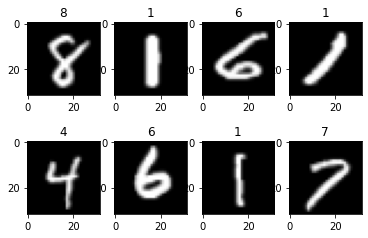

Predicted: "[8 1 6 1 4 6 1 7]", Actual: "[8 1 6 1 4 6 1 7]"


In [23]:
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

mnist = Mnist("./dataset/mnist", split="test", batch_size=8, resize=32)
dataset_infer = mnist.run()
data_test = dataset_infer.create_dict_iterator()
data = next(data_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(images[i-1].squeeze(), cmap="gray")
    plt.title(labels[i-1])
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')

从打印的结果可以看出，预测值与目标值完全一致，说明我们训练的模型达到了很好的识别效果。

> 被预测的图片会随机生成，每次要识别的图片可能会不一样。

### 2.8 实验任务

运用上面所学的知识完成以下实验任务：

1. 基于Mnist数据集，训练一个LeNet-5网络模型实现手写数字识别，要求损失函数使用交叉熵损失函数`SoftmaxCrossEntropyWithLogits`，优化器使用`Momentum`，设置训练轮次为3，批次大小为60，学习率为0.02，动量为0.8。调用`ModelCheckpoint`接口对训练的模型进行保存，要求采用配置时间策略的方式对`CheckpointConfig`进行设置，实现每隔40秒保存一个CheckPoint文件，每隔3分钟保留一个CheckPoint文件，保存路径设置为"./TaskNet"，文件名设置为"task_net"。

2. 基于FashionMnist数据集，训练一个LeNet-5网络模型实现手写商品分类，要求损失函数使用交叉熵损失函数`SoftmaxCrossEntropyWithLogits`，优化器使用`Momentum`，设置训练轮次为5，批次大小为32，学习率为0.01，动量为0.9。调用`ValAccMonitor`接口对训练的模型进行保存，保存路径设置为`"./TaskNet"`。关于FashionMnist数据集的下载和加载用法可以直接使用`mindvision.dataset.FashionMnist`接口，详情可参考[API文档](https://www.mindspore.cn/vision/docs/zh-CN/r0.1/classification.html)。

3. 在实验任务2的基础上，从测试集中随机加载6张图片，实现模型推理，检验模型的预测效果。

#### 参考答案

1. 基于Mnist数据集，训练一个LeNet-5网络模型实现手写数字识别，要求损失函数使用交叉熵损失函数`SoftmaxCrossEntropyWithLogits`，优化器使用`Momentum`，设置训练轮次为3，批次大小为60，学习率为0.02，动量为0.8。调用`ModelCheckpoint`接口对训练的模型进行保存，要求采用配置时间策略的方式对`CheckpointConfig`进行设置，实现每隔40秒保存一个CheckPoint文件，每隔3分钟保留一个CheckPoint文件，保存路径设置为"./TaskNet"，文件名设置为"task_net"。

In [2]:
from mindvision.classification.dataset import Mnist
from mindvision.classification.models import lenet
import mindspore.nn as nn
from mindspore import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 下载并处理MNIST数据集
download_train = Mnist(path="datasets/mnist", split="train", batch_size=32, repeat_num=1, shuffle=True, resize=32, download=True)

dataset_train = download_train.run()

# 定义Lenet-5模型
class LeNet5(nn.Cell):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, num_classes)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

net1 = LeNet5()

# 定义超参数
epochs = 3
batch_size = 60
learning_rate = 0.02
momentum = 0.8

# 定义损失函数
net1_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net1_opt = nn.Momentum(net1.trainable_params(), learning_rate, momentum)

# 使用Model构建训练网络
model = Model(network=net1, loss_fn=net1_loss, optimizer=net1_opt, metrics={"Accuracy": nn.Accuracy()})

# 设置保存模型的配置信息
config_time = CheckpointConfig(save_checkpoint_seconds=40, keep_checkpoint_per_n_minutes=3)

# 实例化保存模型回调接口，定义保存路径和前缀名
ckpoint = ModelCheckpoint(prefix="task_net", directory="./TaskNet/time_strategy", config=config_time)

# 开始训练，加载保存模型和参数回调函数
model.train(epochs, dataset_train, callbacks=[ckpoint])

[WARNING] ME(11836:17444,MainProcess):2022-08-13-15:38:21.563.590 [mindspore\dataset\core\config.py:646] For Windows and MacOS we forbid shared mem function temporarily.


2. 基于FashionMnist数据集，训练一个LeNet-5网络模型实现手写商品分类，要求损失函数使用交叉熵损失函数`SoftmaxCrossEntropyWithLogits`，优化器使用`Momentum`，设置训练轮次为5，批次大小为32，学习率为0.01，动量为0.9。调用`ValAccMonitor`接口对训练的模型进行保存，保存路径设置为`"./TaskNet"`。

In [3]:
from mindvision.classification.dataset import FashionMnist
from mindvision.classification.models import lenet
import mindspore.nn as nn
from mindspore import Model
from mindvision.engine.callback import ValAccMonitor

# 下载并处理FashionMnist数据集
download_train = FashionMnist(path="datasets/FashionMnist", split="train", batch_size=32, resize=32, download=True)
download_eval = FashionMnist(path="datasets/FashionMnist", split="test", batch_size=32, resize=32, download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()

# 定义Lenet-5模型
net2 = LeNet5()

# 定义超参数
epochs = 5
batch_size = 32
learning_rate = 0.01
momentum = 0.9

# 定义损失函数
net2_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net2_opt = nn.Momentum(net2.trainable_params(), learning_rate, momentum)

# 使用Model构建训练网络
model = Model(network=net2, loss_fn=net2_loss, optimizer=net2_opt, metrics={"Accuracy": nn.Accuracy()})

# 开始训练，加载保存模型和参数回调函数
model.train(epochs, dataset_train, callbacks=[ValAccMonitor(model, dataset_eval, num_epochs=epochs, ckpt_directory="./TaskNet")])

[WARNING] ME(11836:17444,MainProcess):2022-08-13-15:44:49.522.478 [mindspore\dataset\core\config.py:646] For Windows and MacOS we forbid shared mem function temporarily.
[WARNING] ME(11836:17444,MainProcess):2022-08-13-15:44:52.430.590 [mindspore\dataset\core\config.py:646] For Windows and MacOS we forbid shared mem function temporarily.


--------------------
Epoch: [  1 /   5], Train Loss: [2.313], Accuracy:  0.100
--------------------
Epoch: [  2 /   5], Train Loss: [2.296], Accuracy:  0.100
--------------------
Epoch: [  3 /   5], Train Loss: [0.457], Accuracy:  0.803
--------------------
Epoch: [  4 /   5], Train Loss: [0.267], Accuracy:  0.845
--------------------
Epoch: [  5 /   5], Train Loss: [0.330], Accuracy:  0.858
End of validation the best Accuracy is:  0.858, save the best ckpt file in ./TaskNet\best.ckpt


3. 在实验任务2的基础上，从测试集中随机加载6张图片，实现模型推理，检验模型的预测效果。

[WARNING] ME(2648:12372,MainProcess):2022-10-11-15:20:57.332.643 [mindspore\dataset\core\config.py:646] For Windows and MacOS we forbid shared mem function temporarily.


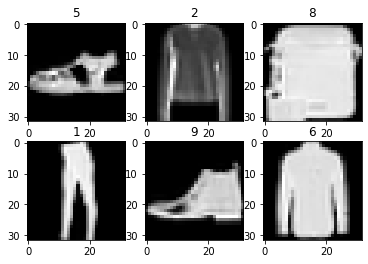

Predicted: "[2 6 2 1 2 4]", Actual: "[5 2 8 1 9 6]"


In [22]:
from mindvision.classification.dataset import FashionMnist
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

Fmnist = FashionMnist("./datasets/FashionMnist", split="test", batch_size=6, resize=32, download=True)
dataset_infer = Fmnist.run()
data_eval = dataset_infer.create_dict_iterator()
data = next(data_eval)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1].squeeze(), cmap="gray")
    plt.title(labels[i-1])
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')